<p style="padding: 10px; border: 1px solid black;">
<img src="../mlu_utils/MLU-NEW-logo.png" alt="drawing" width="400"/> <br/>


# <a name="0">Multimodal Generative AI</a>
## <a name="0">Lab 5: Multimodal Inference</a>

<br>

---
    
This exercise shows how multimodal embeddings can be used for search and retrieval with a sample product dataset. Amazon Titan Multimodal embeddings and the Amazon OpenSearch service will be utilized to enable semantic search based on multiple modalities like title, description and images. This allows finding related products that share conceptual and visual similarities beyond just textual matches.
    
1. <a href="#1">Installing_dependencies</a>
2. <a href="#2">Convert Image to base64</a>
3. <a href="#3">Make Multimodal Predictions</a>
4. <a href="#4">Prompting With Images</a>
5. <a href="#5">Best Practices for Multimodal Prompting</a>
6. <a href="#6">Use Cases</a>
    1. <a href="#6.1">Explain Images</a>
    2. <a href="#6.2">Information Retrieval</a>
    3. <a href="#6.3">Text Extraction and Transcription</a>
    4. <a href="#6.4">Analyze Charts and Graphs</a>
    5. <a href="#6.5">Improve Accessibility</a>
    6. <a href="#6.6">Complex Reasoning and Analysis of Documents</a>
7. <a href="#7">Quizzes</a>
    
---

### <a name="1">Installing dependencies</a>
**Note:** the pip command below might output some error messages. You can disregard them, as they are not affecting the notebook

In [1]:
%%capture
!pip install -q -r ../requirements.txt

In [2]:
import boto3
from botocore.exceptions import ClientError
import os
import base64
import json
import httpx
from IPython.display import Image, display, Markdown, IFrame

import logging
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

### <a name="2">Convert Image to base64</a>

There are scenarios where you need to transmit or store image data along with other types of data, such as text or structured data. However, images are inherently binary data, and directly embedding them in text-based formats like JSON or HTML can be problematic. This is where Base64 encoding comes into play, providing a way to represent binary data as text.

[Base64](https://en.wikipedia.org/wiki/Base64) is an encoding scheme that converts binary data into a sequence of printable ASCII characters. This encoding is particularly useful when you need to embed binary data (like images) in text-based formats or protocols, such as JSON, HTML, or HTTP requests and responses. This can be particularly useful when working with multimodal models like Claude3, which can process both text and images.

In [3]:
def get_base64_encoded_image(image_paths):
    """
    Encode one or more image files or URLs into base64 strings.

    Args:
        image_paths (str or list): A single file path/URL or a list of file paths/URLs.

    Returns:
        tuple: A tuple containing two lists:
            - A list of base64-encoded image strings.
            - A list of corresponding image types.

    Raises:
        ValueError: If an unsupported image format is encountered.
    """
    # Convert input to list if it's a single string
    if isinstance(image_paths, str):
        image_paths = [image_paths]

    images, image_types = [], []

    # Iterate over the image paths/URLs
    for path in image_paths:
        # Check if the path is a URL
        if path.startswith("https://"):
            # url_content = requests.get(path).content
            url_content = httpx.get(path).content
            base64_encoded_data = base64.b64encode(url_content)
            base64_string = base64_encoded_data.decode('utf-8')
        # Otherwise, assume it's a file path
        else:
            with open(path, "rb") as image_file:
                binary_data = image_file.read()
                base64_encoded_data = base64.b64encode(binary_data)
                base64_string = base64_encoded_data.decode('utf-8')

        # Determine the image type based on the file extension
        if path.endswith('.png'):
            image_type = 'image/png'
        elif path.endswith('.jpg') or path.endswith('.jpeg'):
            image_type = 'image/jpeg'
        elif path.endswith('.webp'):
            image_type = 'image/webp'
        elif path.endswith('.gif'):
            image_type = 'image/gif'
        else:
            raise ValueError("Only 'jpeg', 'png', 'webp', and 'gif' image formats are currently supported")

        images.append(base64_string)
        image_types.append(image_type)

    return images, image_types

### <a name="3">Make Multimodal Predictions</a>

Multimodal prompting is a technique that allows language models to process and generate responses based on a combination of text and image inputs. The input consists of textual prompts or questions along with one or more images, often encoded in base64 format with types specified. The language model's architecture and training allow it to understand the relationships between text and visual information. This enables more contextual and visually grounded interactions, useful for applications like image captioning, visual question answering, and multimodal content generation. The generated response can be textual descriptions, answers, or new multimodal outputs, leveraging both modalities for enhanced capabilities.

In [4]:
def invoke_claude_3_multimodal(prompt, images, image_types):
    """
    Invoke the Claude-3 multimodal model from Anthropic using AWS Bedrock runtime.

    Args:
        prompt (str): The text prompt to provide to the model.
        images (list): A list of base64-encoded image data.
        image_types (list): A list of MIME types corresponding to the images.

    Returns:
        str: The model's response text.

    Raises:
        ValueError: If an invalid model name is provided.
    """
    # Initialize the Amazon Bedrock runtime client
    client = boto3.client(service_name="bedrock-runtime", region_name="us-east-1")
    model_id = "anthropic.claude-3-sonnet-20240229-v1:0"

    # Prepare the multimodal prompt message
    message_content = []

    # Add each image to the message content
    for image, img_type in zip(images, image_types):
        message_content.append({
            "type": "image",
            "source": {
                "type": "base64",
                "media_type": img_type,
                "data": image,
            },
        })
    message_content.append({"type": "text", "text": prompt})

    request_body = {
        "anthropic_version": "bedrock-2023-05-31",
        "max_tokens": 2048,
        "temperature": 0.2,
        "top_p": 1.0,
        "top_k": 250,
        "messages": [
            {
                "role": "user",
                "content": message_content,
            }
        ],
    }

    try:
        response = client.invoke_model(
            modelId=model_id,
            body=json.dumps(request_body),
        )

        # Process and return the response
        result = json.loads(response.get("body").read())
        return result['content'][0]['text']

    except ClientError as err:
        logger.error(
            "Couldn't invoke Claude 3 %s model. Here's why: %s: %s",
            model_id.capitalize(),
            err.response["Error"]["Code"],
            err.response["Error"]["Message"],
        )
        raise

## <a name="4">Prompting With Images</a>

Let's try out the multimodal models using prompts containing both images and text.
We will use the following AI-generated image to explore the visual understanding capabilities of Claude3 Sonnet.

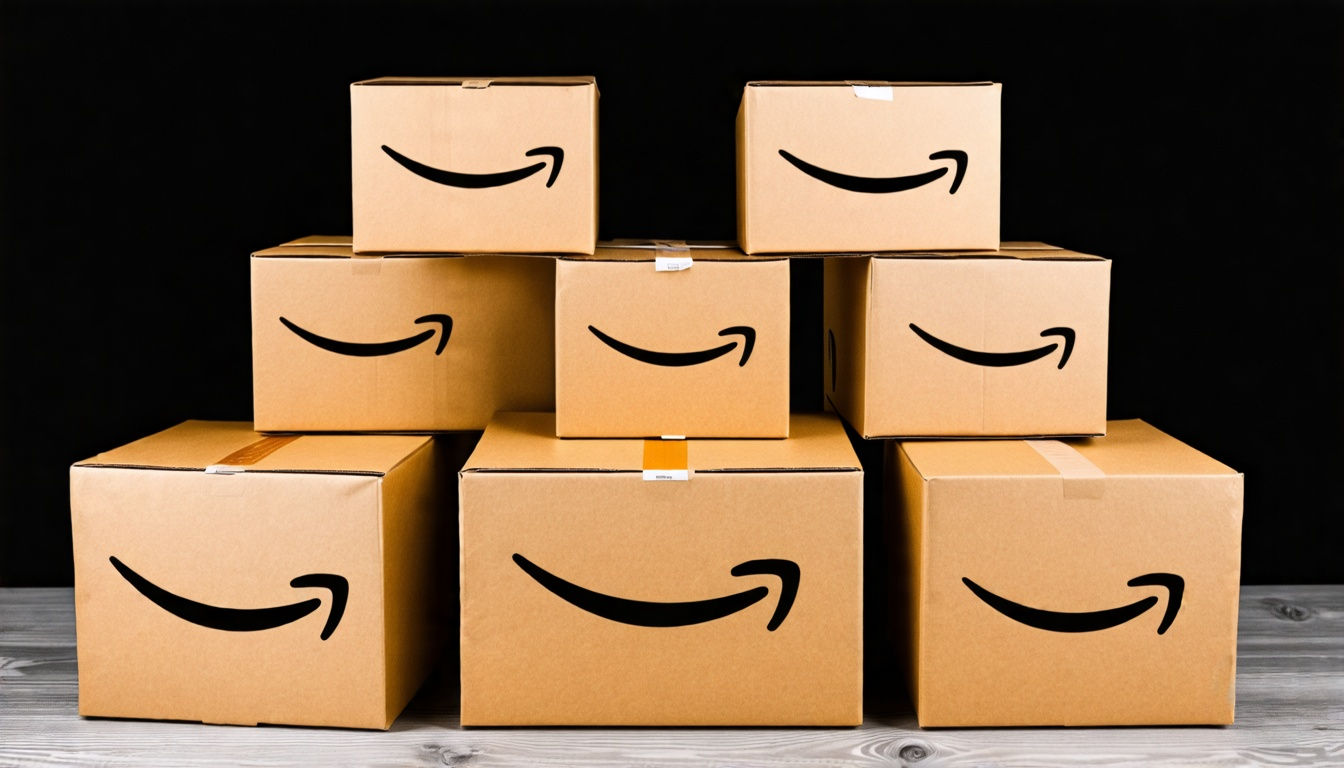

In [5]:
# View Image
Image(filename='content/Amazon-packages.png', width=600)

#### Loading images from local path

To prompt Claude3 with local images, convert the image files to base64 encoding and pass them as a list in the "image" parameter of the multimodal request. This allows Claude3 to analyze the base64-encoded images along with the text prompt.

We will use the helper functions `get_base64_encoded_image` and `invoke_claude_3_multimodal` for prompting.


In [6]:
prompt = "Describe the image."
image_string, image_type = get_base64_encoded_image("content/Amazon-packages.png")

response = invoke_claude_3_multimodal(prompt=prompt, images=image_string, image_types=image_type)
Markdown("<i>"+response+"</i>")

INFO:botocore.credentials:Found credentials from IAM Role: ec2-server-widgets


<i>The image shows several cardboard shipping boxes with the Amazon logo printed on them. There are 8 boxes total, stacked in two rows on what appears to be a wooden surface or floor. The boxes are the signature brown color used by Amazon for their packaging. The Amazon smile logo, consisting of an curved underline beneath the company name, is prominently displayed on each box. The background is completely black, putting the focus entirely on the stacked Amazon boxes.</i>

In [7]:
prompt = "Count the number of boxes in the image."
image_string, image_type = get_base64_encoded_image("content/Amazon-packages.png")

response = invoke_claude_3_multimodal(prompt=prompt, images=image_string, image_types=image_type)
Markdown("<i>"+response+"</i>")

<i>The image shows 8 cardboard boxes with the Amazon smile logo printed on them. The boxes are stacked in two rows on what appears to be a wooden surface or floor against a black background.</i>

Multimodal models are very powerful, yet they may make mistakes when analyzing images as we might observe in the example above.

#### Loading images from url

You can also directly load images from url. The process remains pretty similar as the previous example. The image is retrieved from the url, converted into base64 string and then passed to the model.

Photo by Pixabay from Pexels under Creative Commons license (CC0): https://images.pexels.com/photos/66709/pexels-photo-66709.jpeg

In [8]:
image_url = "https://images.pexels.com/photos/66709/pexels-photo-66709.jpeg"
Image(url=image_url, width=400)

In [9]:
prompt = "Write a sonnet about the object in the image."
image_string, image_type = get_base64_encoded_image(image_url)

response = invoke_claude_3_multimodal(prompt=prompt, images=image_string, image_types=image_type)
Markdown("<i>"+response+"</i>")

INFO:httpx:HTTP Request: GET https://images.pexels.com/photos/66709/pexels-photo-66709.jpeg "HTTP/1.1 200 OK"


<i>Here is a sonnet about the iconic Statue of Liberty depicted in the image:

Colossal gift from France, a beckoning light
To immigrants arriving on freedom's shore,
Your regal stance and torch held burning bright
Proclaim the nation's promise evermore.
Your crown of rays illuminates the way
For huddled masses yearning to breathe free,
A verdant symbol raised in New York's bay,
The Mother of Exiles from tyranny.

Uplifted arm with tablet graven clear -
"Give me your tired, your poor" the words inspire
All those who prize liberty and revere
This land of opportunity they admire.
Proud Lady Liberty, your stoic beauty
Remains a global emblematic duty.</i>

## <a name="5">Best Practices for Multimodal Prompting</a>

As multimodal models become more advanced and capable of understanding different data modalities like text, images, and audio, it's crucial to follow established best practices when prompting these models. Adhering to guidelines helps ensure the outputs generated are relevant and expected.

Maintain standard best practices for prompting such as providing clear and specific prompts, avoiding ambiguity, and carefully curating the data inputs. Best practices also emphasize the importance of maintaining user privacy and respecting intellectual property rights. For instance, being thoughtful about what images or audio clips are uploaded to avoid unintentionally sharing personal or copyrighted content.  

Moreover, best practices guide users on how to interpret model outputs appropriately, understanding the inherent limitations of AI systems and that responses should be validated against authoritative sources. Following these recommendations ultimately leads to more trustworthy and reliable interactions with cutting-edge AI capabilities.

#### Know your model's capabilities and limitations

It is important to consider the selected model's known capabilities and limitations while prompting the model. In this lab, we are using the Claude3 models which have the following guidelines for effective prompting:

Claude 3 Models:
- **Input Format**: Images need to be provided in a base64-encoded format.
- **Image Size**: Individual image size cannot exceed 5MB
- **Multiple Images**: Claude 3 models supports prompting with up to 5 images.
- **Image Format**: Supported image formats: 'PNG', 'JPEG', 'WebP' and 'GIF'.
- **Image Clarity**: Clear images which are not too blurry are more effective with Claude 3 models.
- **Image Placement**: Claude 3 models work better when images come before text while prompting. However, if the use case requires, images can follow text or can be interpolated with text.
- **Image Resolution**: If the image's long edge is more than 1568 pixels, or the image is more than ~1600 tokens, it will first be scaled down, preserving aspect ratio, until it is within size limits. If the input image is too large and needs to be resized, it will increase latency of time-to-first-token, without giving you any additional model performance. Very small images under 200 pixels on any given edge may lead to degraded performance.


<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h2><i>Activity: Text and image search</i></h2>
    <br>
    <p style="text-align:center;margin:auto;"><img src="../mlu_utils/activity.png" alt="Activity" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">Try prompting the Claude3 models with your own prompts. Explore how the quality and accuracy of responses changes with Image Resolution, Formats, Placement, etc</p>
    <br>
</div>

In [10]:
############## CODE HERE ####################



############## END OF CODE ##################

## <a name="6">Use Cases</a>

### <a name="6.1">1) Explain Images</a>

When it comes to describing images, multimodal models can be extremely useful. These models can take an image as input and generate a description that captures the important elements and context within the visual. This has a wide range of applications, including helping people with visual impairments understand images, generating image captions for social media posts, or even creating descriptions for product images in online stores to enhance the user experience and improve accessibility.

Let's use a multimodal model to describe the following architecture of a chatbot application using several AWS products. The application uses Bedrock Knowledge Bases to store content from S3 using OpenSearch vector stores. The chatbot application accesses a Lambda function through a Firewall-protected API Gateway which then uses Bedrock to generate a response using the retrieved context from the knowledge base. The response is finally returned back to the chatbot application.

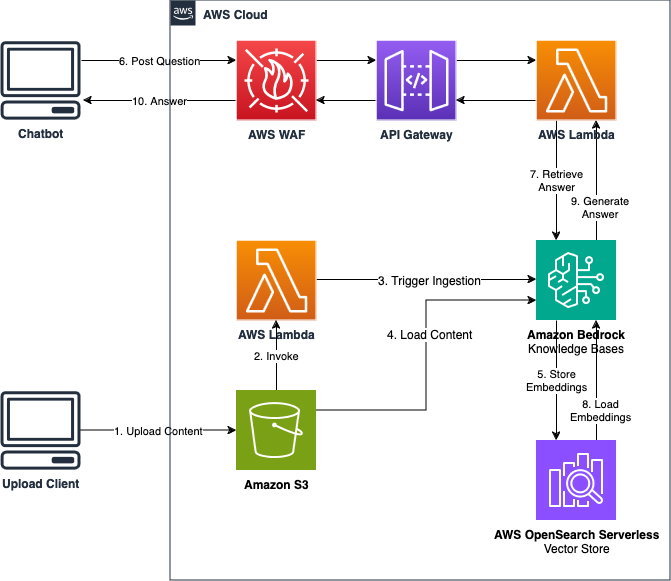

In [11]:
Image("content/Chatbot-Architecture.png", width="60%")

In [12]:
prompt = "The image is an AWS architecture diagram to build a chatbot using AWS services. Which service serves as a vector database for the chatbot?"
image_string, image_type = get_base64_encoded_image("content/Chatbot-Architecture.png")

response = invoke_claude_3_multimodal(prompt=prompt, images=image_string, image_types=image_type)
Markdown("<i>"+response+"</i>")

<i>According to the architecture diagram, the AWS OpenSearch Service (labeled as "AWS OpenSearch Serverless Vector Store") serves as the vector database for storing and retrieving embeddings used by the chatbot.</i>

#### Limitation with GIFs and WebP Content

Multimodal models like Claude3 have the ability to process and understand multiple types of input data, such as text, images, and audio. However, when it comes to video or GIF data, there is a limitation in their native ability to analyze individual frames.

Videos and GIFs are essentially sequences of images or frames played in rapid succession to create the illusion of motion. Each frame can contain unique visual information, such as the movement of objects, changes in lighting or colors, or the appearance or disappearance of elements.

Several multimodal models, including Claude3 models, only parse the first frame of a GIF when prompted with it. This limitation prevents the model from analyzing each frame natively and loses the ability to explain the complete animation.

A possible solution could be stacking all the frames into a single image and prompting the model with it. However, that makes the image very complicated, and the model may not be able to analyze the slight differences in each subsequent frame to understand the animation. Recently, there have been a few models that come with the ability to process and analyze video frames to describe videos.

Let's try to prompt Claude3 Sonnet with this [GIF](https://commons.wikimedia.org/wiki/File:SdKfz_250-1_(Neu)_(3D-animated).gif):

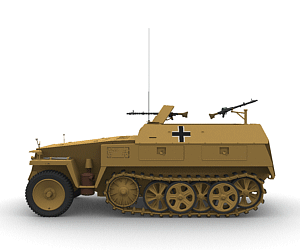

In [13]:
Image("content/animated_truck.gif", width="2000%")

In [14]:
prompt = "Explain this GIF."
image_string, image_type = get_base64_encoded_image("content/animated_truck.gif")

response = invoke_claude_3_multimodal(prompt=prompt, images=image_string, image_types=image_type)
Markdown("<i>"+response+"</i>")

<i>This is not a GIF, but rather a 3D rendered image of a military armored personnel carrier or infantry fighting vehicle.

The vehicle appears to be a tracked, lightly armored transport designed to carry troops into combat zones while providing protection from small arms fire and artillery shrapnel. It has a boxy, angular design typical of many modern armored vehicles.

The main features visible are the tracked wheels/road wheels for mobility over rough terrain, a rear door ramp likely for entry/exit of personnel, and what seems to be a turret or weapon station mounted on top capable of housing a machine gun or automatic cannon for defensive firepower.

The vehicle has a sandy/tan camouflage paint scheme, suggesting it is designed for desert or arid environment operations. Overall, this digital rendering depicts a modern military armored personnel carrier or infantry fighting vehicle utilized by armed forces around the world.</i>

### <a name="6.2">2) Information Retrieval</a>

With documents, these models excel at processing complex layouts and understanding the relationship between text and visual elements. They can extract text from images, understand tables, charts, and graphs, and even interpret hand-written notes. By combining textual and visual understanding, these models provide a comprehensive understanding of the document, making information extraction accurate and contextually aware. 

The key advantage of multimodal models lies in their ability to bring together disparate sources of information and make inferences that were previously challenging for traditional, single-modality AI systems. 

Here we will use the [Open-LLM-Leaderboard](https://github.com/VILA-Lab/Open-LLM-Leaderboard) results presented by Myrzakhan et. al.

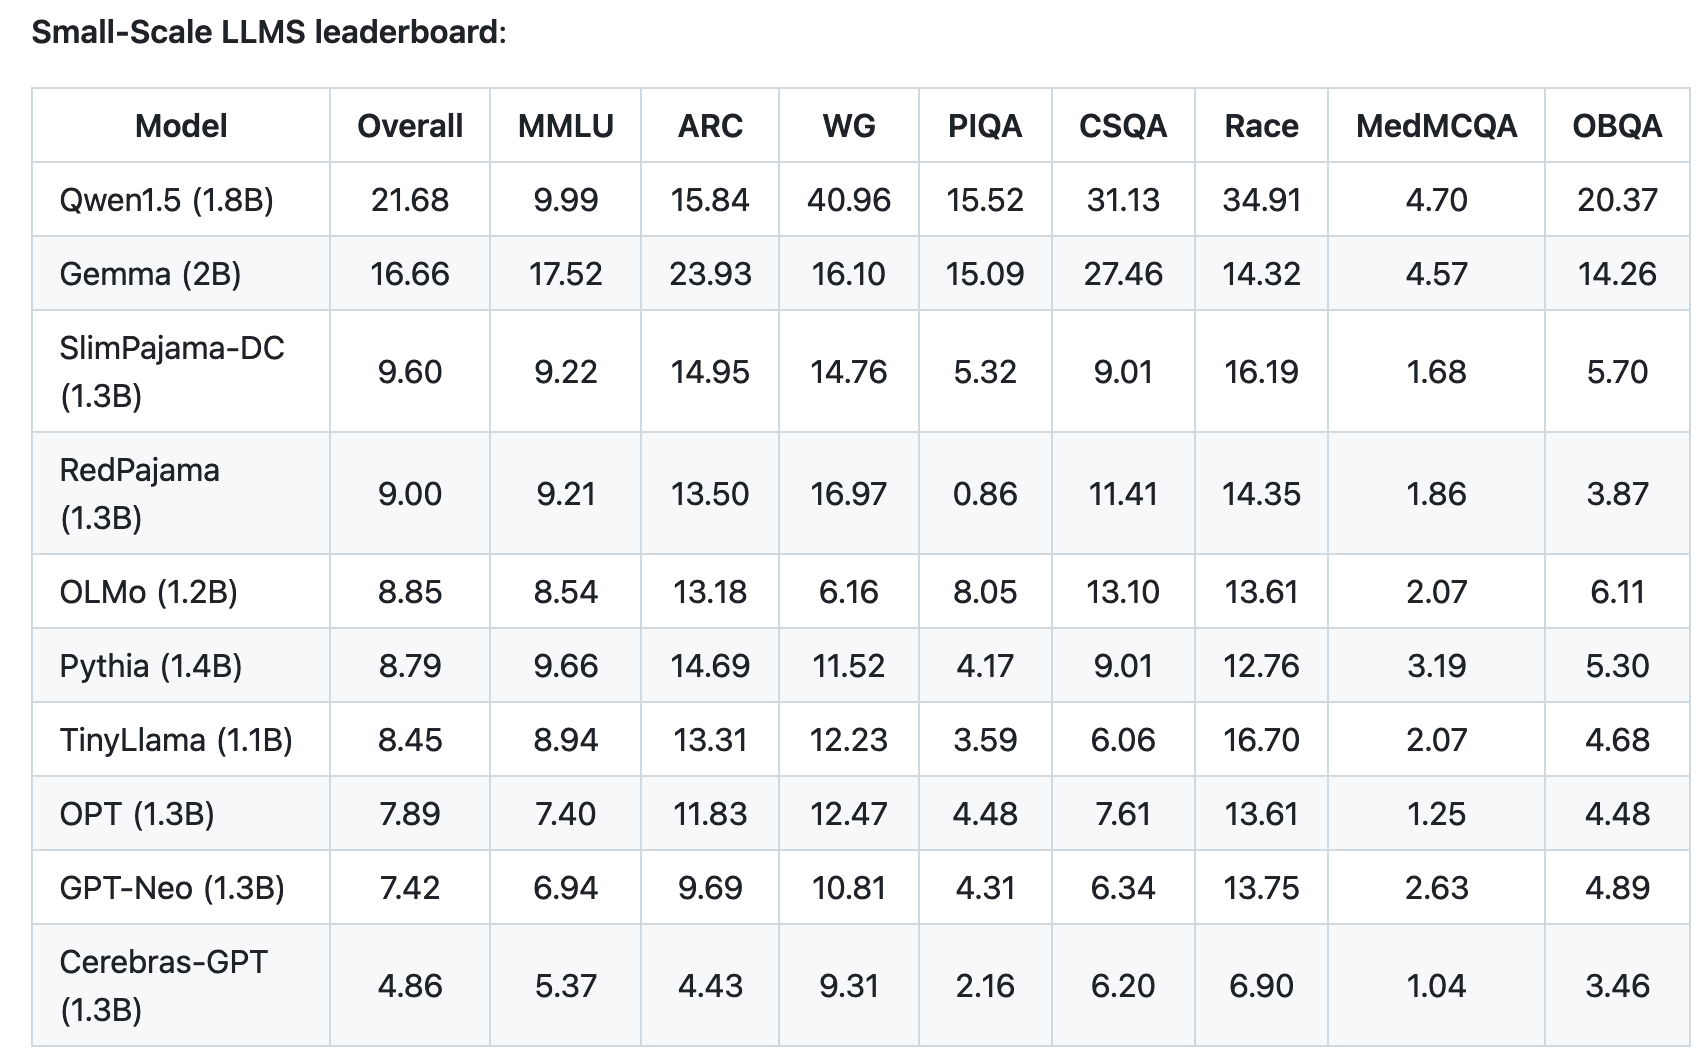

In [15]:
Image("content/Open-LLM-Leaderboard.png", width=800)

In [16]:
prompt = """The image depicts a leaderboard measuring the performance of various open-source LLMs on evaluation tasks such as MMLU, ARC, WG, etc. \
How did OLMo score on MMLU? Find the model name in the first column and find the corresponding evaluation metric in the MMLU column."""
image_string, image_type = get_base64_encoded_image("content/Open-LLM-Leaderboard.png")

response = invoke_claude_3_multimodal(prompt=prompt, images=image_string, image_types=image_type)
Markdown("<i>"+response+"</i>")

<i>According to the leaderboard shown in the image, the OLMo (1.2B) model scored 8.54 on the MMLU (Multitask Multilingual) evaluation metric.</i>

### <a name="6.3">3) Text Extraction and Transcription</a>

For applications such as text extraction, these models can identify and extract relevant information from documents, images, or even videos. They excel at recognizing and interpreting text within complex layouts, such as tables, forms, or infographics. By understanding the context and structure of the source material, the models can accurately extract specific data points, summaries, or key information, making it readily available for further analysis or processing.

Let's try asking questions about the following [image](https://commons.wikimedia.org/wiki/File:ReceiptSwiss.jpg) of a receipt. The receipt shows that the customer purchased several items with a total cost of `54.50 CHF`. Let's ask questions about this receipt and observe the attention to details in the response.

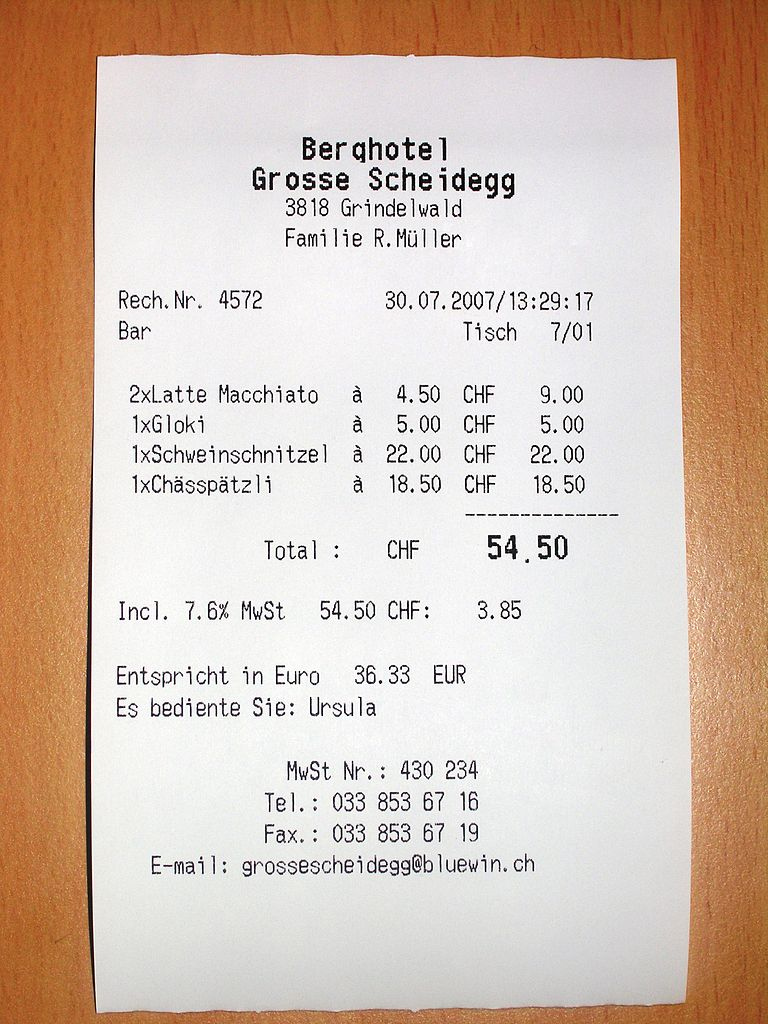

In [17]:
Image("content/Payment-receipt.jpg", width=500)

In [18]:
prompt = "What did the customer buy and how much did it cost in CHF?"
image_string, image_type = get_base64_encoded_image("content/Payment-receipt.jpg")

response = invoke_claude_3_multimodal(prompt=prompt, images=image_string, image_types=image_type)
print(response)

According to the receipt, the customer bought the following items and their respective costs in Swiss Francs (CHF):

2x Latte Macchiato at CHF 4.50 each = CHF 9.00
1x Glöki (possibly a type of hot beverage) at CHF 5.00
1x Schweinschnitzel (pork schnitzel) at CHF 22.00
1x Châsspätzli (Swiss pasta dish) at CHF 18.50

The total cost was CHF 54.50 including a 7.6% tax (MwSt) of CHF 3.85.


### <a name="6.4">4) Analyze Charts and Graphs</a>

Multimodal models are now being leveraged to analyze and interpret charts and graphs, offering a powerful way for understanding complex data visualizations. With their advanced capabilities, these models can provide valuable insights and support data-driven decision-making.

These models can identify and classify different types of visualizations, including bar graphs, pie charts, line graphs, and scatter plots, among others. By understanding the structural and visual elements, these models can extract crucial information, such as labels, legends, data values, and their relationships. 

One of the key strengths of multimodal models lies in their ability to provide contextual understanding. They can interpret chart titles, axis labels, and captions to grasp the underlying narrative of the visualization. By combining this with their text and image analysis capabilities, they can explain the insights presented, identify trends and patterns, and even generate descriptive summaries or highlight key takeaways. 

Moreover, these models can assist in comparing and contrasting multiple charts, identifying similarities, and relationships between datasets. This capability is particularly useful for spotting anomalies, making predictions, or generating insights that might otherwise be difficult to discern. By bringing together text, image, and even tabular data interpretation, multimodal models enhance the accessibility and comprehension of chart-based information, enabling users to make more informed decisions.

We will use the following [chart](https://commons.wikimedia.org/wiki/File:Land_vs_Ocean_Temperature.svg) illustrating how global average temperatures on the land surface and ocean surface have changed over the years. The chart is plotted at intervals of 10 years from 1950 to 2020. The chart shows that the average global temperatures on the land surface and ocean surface have steadily been increasing since 1950.

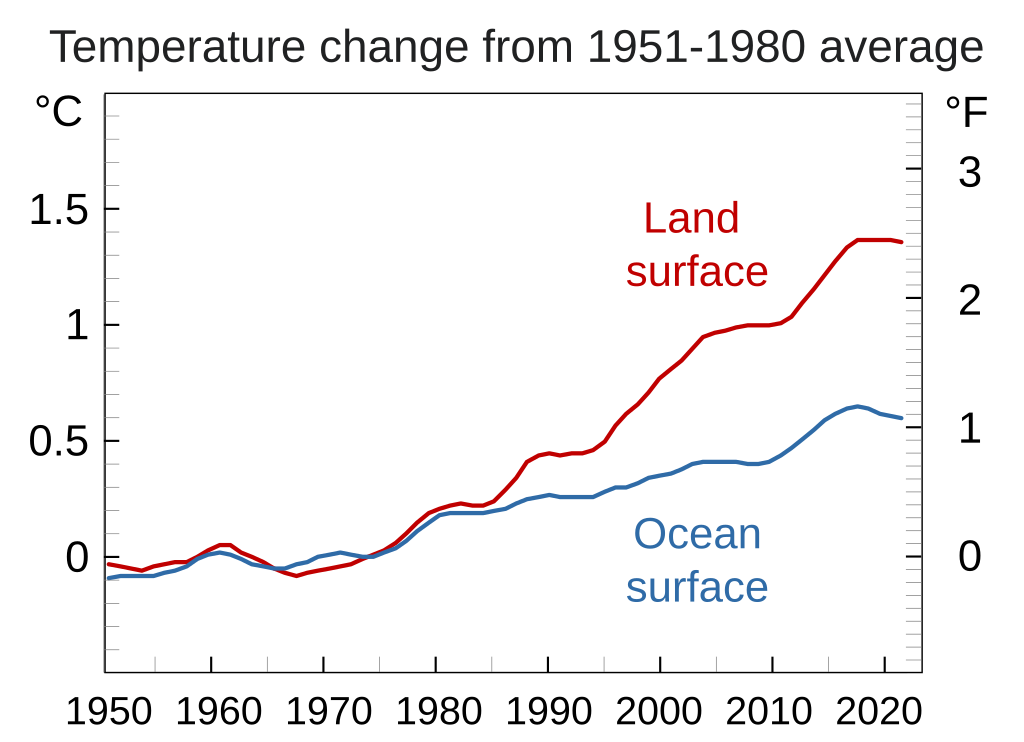

In [19]:
Image("content/Chart-data.png", width=800)

In [20]:
prompt = "Explain the trend of global temperature between 1950 and 2000."
image_string, image_type = get_base64_encoded_image("content/Chart-data.png")

response = invoke_claude_3_multimodal(prompt=prompt, images=image_string, image_types=image_type)
Markdown("<i>"+response+"</i>")

<i>The graph shows the change in global temperature from the 1951-1980 average for both land surface and ocean surface temperatures from 1950 to the present day.

Between 1950 and 2000, there is a clear upward trend in temperatures for both land and ocean surfaces, indicating a rise in global temperatures during this period.

The land surface temperature (red line) shows a steeper increase compared to the ocean surface temperature (blue line). The land surface temperature rise appears to accelerate more rapidly starting around the 1980s.

While there are some fluctuations year-to-year, the overall trajectory for both land and ocean temperatures is an upward warming trend from 1950 through 2000, reflecting the effects of global warming and climate change during the latter half of the 20th century.</i>

### <a name="6.5">5) Improve Accessibility</a>

Multimodal models are revolutionizing the field of accessibility by generating descriptive content for images and scenes, making digital content more inclusive for all users. 

One of the key applications of these models is in the creation of alt-text for images. By analyzing the visual content, multimodal models can generate descriptive alt-text that conveys the image's key information. This alt-text is crucial for individuals with visual impairments, as it allows them to understand the context and significance of images through assistive technologies like screen readers. The models can identify objects, recognize scenes, and describe the image's composition, ensuring a rich and detailed portrayal. 

Additionally, these models can provide detailed scene descriptions, offering a narrative-like explanation of what is happening in a given image or video frame. This goes beyond simple object recognition by capturing the atmosphere, actions, and relationships between elements. Scene descriptions are particularly beneficial for those with visual or cognitive disabilities, as they paint a comprehensive mental picture, enhancing their understanding and engagement with the content. We will further explore this this application in Lab5.

Let's consider the following [image](https://commons.wikimedia.org/wiki/File:Asl_alphabet_gallaudet.svg) representing the ASL (American Sign Language) alphabets, laid out by Darren Stone.

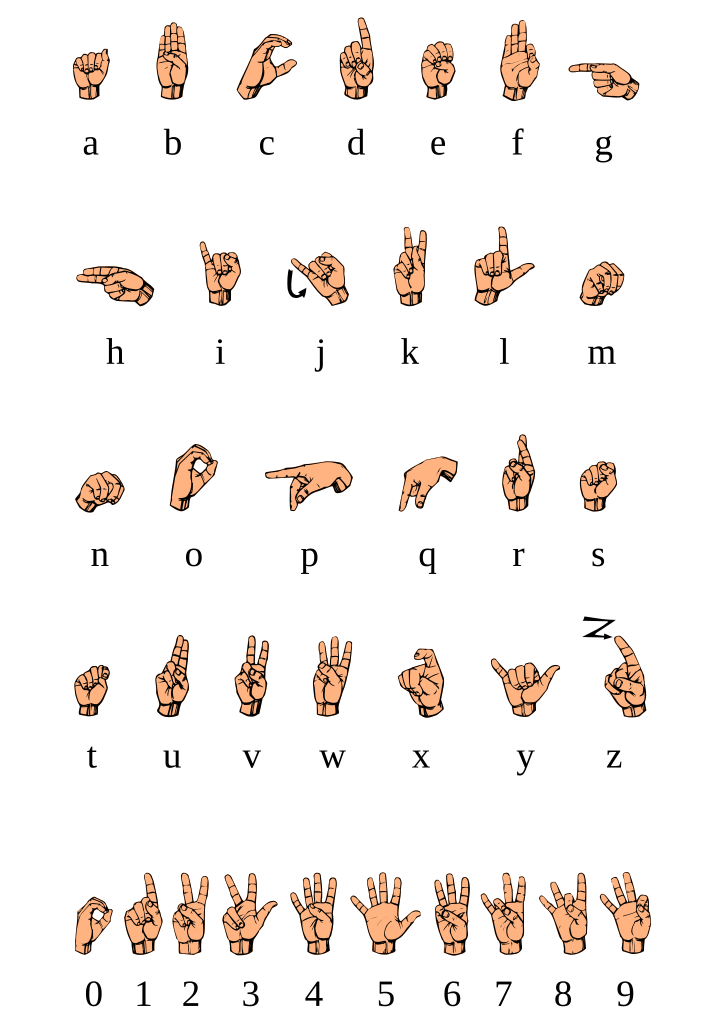

In [21]:
Image("content/asl.png", width=800)

In [22]:
prompt = "Produce alt-text for the given image following the guidelines."
guidelines = """ Guidelines for alt-text:
- Be succinct but convey the same information a sighted customer receives from the image.
- Keep alt text length to 155 characters or less for SEO reasons.
- Don't duplicate text already in the content.
- Avoid phrases like "image of ..." or "graphic of ..." to describe the image. Screen readers already indicate that alt text is part of an image.
- Include punctuation when needed. When screen readers encounter punctuation, they pause before continuing.
- Avoid using all-caps in alt text. Some screen readers read capital letters individually.
"""

image_string, image_type = get_base64_encoded_image("content/asl.png")

response = invoke_claude_3_multimodal(prompt=prompt + "\n" + guidelines, images=image_string, image_types=image_type)
Markdown("<i>"+response+"</i>")

<i>The image displays an illustrated alphabet with each letter represented by a hand gesture or sign from American Sign Language. Below the alphabet are numbered hand signs representing digits from 0 to 9. The illustrations show diverse skin tones for the hands.</i>

### <a name="6.6">6) Complex Reasoning and Analysis of Documents</a>

Multimodal models are effective tools for parsing, analyzing, and retrieving information from documents such as PDFs, offering a seamless way to extract valuable insights from a variety of sources. 

One of the key strengths of these models is their ability to process and understand structured and unstructured data within PDFs. They can parse through tables, forms, charts, and free-form text, recognizing and extracting relevant information. Whether it's extracting specific data points, identifying patterns, or understanding contextual relationships, multimodal models provide a comprehensive understanding of the document's content. 

Another advantage is their capability to interpret and analyze visual elements, such as graphs, diagrams, and images, often found in PDFs. By combining image recognition with textual analysis, these models can explain and provide insights from visual representations, making the information more accessible and actionable. This is particularly useful for industries that rely on visual data, such as engineering, architecture, or scientific research. 

By leveraging the power of multimodal AI, the process of parsing, analyzing, and retrieving information from PDFs becomes more efficient and robust. Models like Claude3 enable users to unlock valuable insights, make data-driven decisions, and easily access the information they need, regardless of the document's format or structure. This enhances productivity, facilitates knowledge sharing, and improves the overall user experience when working with PDF documents.

Let's try to analyze the following [PDF](https://docs.aws.amazon.com/bedrock/latest/userguide/titan-text-models.html) about Amazon's Titan Models.

In [23]:
IFrame("content/Titan Models-Docs.pdf", width=600, height=800)

In [24]:
# Helper function to convert pdf to images
def pdf2img(pdf_path, pdf_pages_dir):
    import pypdfium2 as pdfium
    from PIL import Image as pilimage
    
    pdf = pdfium.PdfDocument(pdf_path)

    if not os.path.exists(pdf_pages_dir):
        os.makedirs(pdf_pages_dir)

    resolution = pdf.get_page(0).render().to_numpy().shape
    scale = 1 if resolution[0] >= 1620 or resolution[1] >=1620 else 300/72
    n_pages = len(pdf)
    for page_number in range(n_pages):
        page = pdf.get_page(page_number)
        pil_image = page.render(
            scale=scale,
            rotation=0,
            crop=(0, 0, 0, 0),
            may_draw_forms=False,
            fill_color=(255, 255, 255, 255),
            draw_annots=False,
            grayscale=False,
        ).to_pil()
        width, height = pil_image.size
        pil_image = pil_image.resize((width//2*2, height//2*2), pilimage.LANCZOS)
        pil_image.save(os.path.join(pdf_pages_dir, "page_{}.png".format(str(page_number).zfill(3))))

In [25]:
def analyse_pdf(prompt, pdf_path):
    
    pdf_pages_dir = "pdf_pages"
    pdf2img(pdf_path=pdf_path, pdf_pages_dir=pdf_pages_dir)
    
    # Check whether the pdf has less than or equal to 5 pages
    if len(os.listdir(pdf_pages_dir)) > 5:
        raise ValueError("For Claude 3, only 5 page PDFs are supported.")
        
    image_strings, image_types = get_base64_encoded_image([os.path.join(pdf_pages_dir, file) for file in sorted(os.listdir(pdf_pages_dir))])
    response = invoke_claude_3_multimodal(prompt=prompt, images=image_strings, image_types=image_types)
    return response

In [26]:
pdf_path = "content/Titan Models-Docs.pdf"
prompt = "What is the 'max token' value for Titan Premier?"

response = analyse_pdf(prompt, pdf_path)
Markdown("<i>"+response+"</i>")

<i>According to the information provided in the images, the Max tokens value for Amazon Titan Text G1 - Premier model is 32K.</i>

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h2><i>Activity: Text and image search</i></h2>
    <br>
    <p style="text-align:center;margin:auto;"><img src="../mlu_utils/activity.png" alt="Activity" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">Analyzing PDFs this way can be quite challenging as the model is attempting to process multiple images which contain a lot of text. <br>
        Try a few more prompts to explore the model's capability in answering specific questions about the content in the PDF.</p>
    <br>
</div>

In [27]:
############## CODE HERE ####################



############## END OF CODE ##################

---
### <a name="7">Quiz Questions</a>

Well done completing the lab! Now, it's time for a brief knowledge assessment.

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h2><i>Try it Yourself!</i></h2>
    <br>
    <p style="text-align:center;margin:auto;"><img src="../mlu_utils/challenge.png" alt="Challenge" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">Answer the following questions to test your understanding of using MLLMs for inference.</p>
    <br>
</div>

In [28]:
import sys
sys.path.append('..')
from mlu_utils.quiz_questions import *

lab5_question1

In [29]:
lab5_question2

# Thank you!

<p style="padding: 10px; border: 1px solid black;">
<img src="../mlu_utils/MLU-NEW-logo.png" alt="drawing" width="400"/> <br/>